In [61]:
import pandas as pd

df = pd.read_csv("CHIKBR25.csv")
df.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,...,PLAQ_MENOR,CON_FHD,COMPLICA,NU_LOTE_I,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A92.0,2025-05-24,202521,2025,12,120033,1941,2000083.0,2025-05-21,...,NaN,NaN,NaN,NaN,2.0,NaN,2025-12-09,0,NaN,NaN
1,2,A92.0,2025-12-08,202550,2025,12,120020,1941,5336171.0,2025-12-05,...,NaN,NaN,NaN,NaN,NaN,NaN,2025-12-09,0,NaN,NaN
2,2,A92.0,2025-12-04,202549,2025,12,120040,1938,2001586.0,2025-11-20,...,NaN,NaN,NaN,NaN,2.0,NaN,2025-12-11,0,NaN,NaN
3,2,A92.0,2025-12-03,202549,2025,12,120040,1938,6119697.0,2025-12-03,...,NaN,NaN,NaN,NaN,NaN,NaN,2025-12-11,0,NaN,NaN
4,2,A92.0,2025-12-06,202549,2025,12,120040,1938,2000733.0,2025-11-29,...,NaN,NaN,NaN,NaN,2.0,NaN,2025-12-10,0,NaN,NaN


In [62]:
# Quantidade de linhas e colunas
df.shape

(239491, 122)

In [63]:
# Analisando as informações do dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239491 entries, 0 to 239490
Columns: 122 entries, TP_NOT to MIGRADO_W
dtypes: float64(97), int64(13), object(12)
memory usage: 222.9+ MB


In [64]:
# Remover colunas irrelevantes ou com muitos valores ausentes

drop_cols = [
    "tp_", "id_", "cod", "codigo", "nu_", "co_",
    "dt_", "data", "ano", "semana",
    "uf", "municip", "regiao", "pais",
    "notifica", "notific", "digita", "atualiza",
    "sistema", "fluxo", "origem",
    "migr", "versao", "status",
    "lote", "usuario", "login", "sem_", "cs_escol_n", 
    "hospitaliz", "comuninf", "evolucao", "doenca_tra", 
    "nduplic_n", "cs_flxret", "flxrecebi", "tpautocto"
]

def is_to_remove(col_name):
    col_name = col_name.lower()
    return any(pat in col_name for pat in drop_cols)


cols_to_drop = [col for col in df.columns if is_to_remove(col)]

print(f"Quantidade de colunas removida: {len(cols_to_drop)}")
print(f"Colunas removidas: {cols_to_drop}")

df = df.drop(columns=cols_to_drop)
print("Dimensão após limpeza:", df.shape)

Quantidade de colunas removida: 50
Colunas removidas: ['TP_NOT', 'ID_AGRAVO', 'DT_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP', 'ID_REGIONA', 'ID_UNIDADE', 'DT_SIN_PRI', 'SEM_PRI', 'ANO_NASC', 'NU_IDADE_N', 'CS_ESCOL_N', 'SG_UF', 'ID_MN_RESI', 'ID_RG_RESI', 'ID_PAIS', 'DT_INVEST', 'ID_OCUPA_N', 'DT_CHIK_S1', 'DT_CHIK_S2', 'DT_PRNT', 'DT_SORO', 'DT_NS1', 'DT_VIRAL', 'DT_PCR', 'HOSPITALIZ', 'DT_INTERNA', 'UF', 'MUNICIPIO', 'TPAUTOCTO', 'COUFINF', 'COPAISINF', 'COMUNINF', 'DOENCA_TRA', 'EVOLUCAO', 'DT_OBITO', 'DT_ENCERRA', 'DT_ALRM', 'GRAV_INSUF', 'DT_GRAV', 'LACO_N', 'NU_LOTE_I', 'TP_SISTEMA', 'NDUPLIC_N', 'DT_DIGITA', 'CS_FLXRET', 'FLXRECEBI', 'MIGRADO_W']
Dimensão após limpeza: (239491, 72)


In [65]:
print("Colunas restantes:", df.columns.tolist())

Colunas restantes: ['CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RES_CHIKS1', 'RES_CHIKS2', 'RESUL_PRNT', 'RESUL_SORO', 'RESUL_NS1', 'RESUL_VI_N', 'RESUL_PCR_', 'SOROTIPO', 'HISTOPA_N', 'IMUNOH_N', 'CLASSI_FIN', 'CRITERIO', 'CLINC_CHIK', 'ALRM_HIPOT', 'ALRM_PLAQ', 'ALRM_VOM', 'ALRM_SANG', 'ALRM_HEMAT', 'ALRM_ABDOM', 'ALRM_LETAR', 'ALRM_HEPAT', 'ALRM_LIQ', 'GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_TAQUI', 'GRAV_EXTRE', 'GRAV_HIPOT', 'GRAV_HEMAT', 'GRAV_MELEN', 'GRAV_METRO', 'GRAV_SANG', 'GRAV_AST', 'GRAV_MIOC', 'GRAV_CONSC', 'GRAV_ORGAO', 'MANI_HEMOR', 'EPISTAXE', 'GENGIVO', 'METRO', 'PETEQUIAS', 'HEMATURA', 'SANGRAM', 'PLASMATICO', 'EVIDENCIA', 'PLAQ_MENOR', 'CON_FHD', 'COMPLICA']


In [66]:
# Analisando as informações do dataset após limpeza
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239491 entries, 0 to 239490
Data columns (total 72 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CS_SEXO     239491 non-null  object 
 1   CS_GESTANT  239464 non-null  float64
 2   CS_RACA     239491 non-null  int64  
 3   FEBRE       235342 non-null  float64
 4   MIALGIA     235342 non-null  float64
 5   CEFALEIA    235342 non-null  float64
 6   EXANTEMA    235342 non-null  float64
 7   VOMITO      235342 non-null  float64
 8   NAUSEA      235342 non-null  float64
 9   DOR_COSTAS  235342 non-null  float64
 10  CONJUNTVIT  235342 non-null  float64
 11  ARTRITE     235342 non-null  float64
 12  ARTRALGIA   235342 non-null  float64
 13  PETEQUIA_N  235342 non-null  float64
 14  LEUCOPENIA  235342 non-null  float64
 15  LACO        235342 non-null  float64
 16  DOR_RETRO   235342 non-null  float64
 17  DIABETES    235342 non-null  float64
 18  HEMATOLOG   235342 non-null  float64
 19  HE

In [67]:
# Quantidade de nulos em cada coluna
df.isnull().sum()

CS_SEXO            0
CS_GESTANT        27
CS_RACA            0
FEBRE           4149
MIALGIA         4149
               ...  
PLASMATICO    239491
EVIDENCIA     239491
PLAQ_MENOR    239491
CON_FHD       239491
COMPLICA      239491
Length: 72, dtype: int64

In [68]:
# Calcula a proporção de valores nulos por coluna
null_ratio = df.isnull().mean()

null_ratio.sort_values(ascending=False)

ALRM_VOM      1.000000
IMUNOH_N      1.000000
ALRM_PLAQ     1.000000
ALRM_HIPOT    1.000000
RESUL_NS1     1.000000
                ...   
HEPATOPAT     0.017324
AUTO_IMUNE    0.017324
CS_GESTANT    0.000113
CS_SEXO       0.000000
CS_RACA       0.000000
Length: 72, dtype: float64

In [69]:
# Remover colunas com mais de 100% de valores nulos

null_threshold = 1.0

df = df.loc[:, df.isnull().mean() < null_threshold]

print("Após remoção por nulos:", df.shape)

Após remoção por nulos: (239491, 28)


In [70]:
print("Colunas restantes:", df.columns.tolist())

Colunas restantes: ['CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT', 'AUTO_IMUNE', 'RESUL_VI_N', 'CLASSI_FIN', 'CRITERIO', 'CLINC_CHIK']


In [71]:
# Calcula a proporção de valores nulos por coluna
null_ratio = df.isnull().mean()

null_ratio.sort_values(ascending=False)

RESUL_VI_N    0.537051
CLINC_CHIK    0.402913
CLASSI_FIN    0.092621
CRITERIO      0.078500
NAUSEA        0.017324
DOR_COSTAS    0.017324
CONJUNTVIT    0.017324
VOMITO        0.017324
FEBRE         0.017324
EXANTEMA      0.017324
CEFALEIA      0.017324
MIALGIA       0.017324
HEPATOPAT     0.017324
HEMATOLOG     0.017324
DIABETES      0.017324
ARTRITE       0.017324
ARTRALGIA     0.017324
PETEQUIA_N    0.017324
LEUCOPENIA    0.017324
LACO          0.017324
AUTO_IMUNE    0.017324
ACIDO_PEPT    0.017324
HIPERTENSA    0.017324
DOR_RETRO     0.017324
RENAL         0.017324
CS_GESTANT    0.000113
CS_SEXO       0.000000
CS_RACA       0.000000
dtype: float64

In [72]:
df["CLINC_CHIK"].value_counts()

CLINC_CHIK
1.0    141572
2.0      1425
Name: count, dtype: int64

In [73]:
drop_cols = ["cs_", "clinc_chik", "criterio", "resul_"]

cols_to_drop = [col for col in df.columns if is_to_remove(col)]

print(f"Quantidade de colunas removida: {cols_to_drop}")

df = df.drop(columns=cols_to_drop)
print("Dimensão após limpeza:", df.shape)

Quantidade de colunas removida: ['CS_SEXO', 'CS_GESTANT', 'CS_RACA', 'RESUL_VI_N', 'CRITERIO', 'CLINC_CHIK']
Dimensão após limpeza: (239491, 22)


In [74]:
df.head()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,...,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,CLASSI_FIN
0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.0
1,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
2,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,...,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN
3,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
4,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN


In [75]:
# Remover dados nulos do campo "CLASSI_FIN"

df = df[df["CLASSI_FIN"].notnull()]

df.isnull().sum()   

FEBRE         3
MIALGIA       3
CEFALEIA      3
EXANTEMA      3
VOMITO        3
NAUSEA        3
DOR_COSTAS    3
CONJUNTVIT    3
ARTRITE       3
ARTRALGIA     3
PETEQUIA_N    3
LEUCOPENIA    3
LACO          3
DOR_RETRO     3
DIABETES      3
HEMATOLOG     3
HEPATOPAT     3
RENAL         3
HIPERTENSA    3
ACIDO_PEPT    3
AUTO_IMUNE    3
CLASSI_FIN    0
dtype: int64

In [76]:
from sklearn.impute import SimpleImputer
import numpy as np
# Preenche os valores NaN com a mediana das colunas
imputer = SimpleImputer(missing_values= np.nan, strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

df.isnull().sum()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217309 entries, 0 to 217308
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   FEBRE       217309 non-null  float64
 1   MIALGIA     217309 non-null  float64
 2   CEFALEIA    217309 non-null  float64
 3   EXANTEMA    217309 non-null  float64
 4   VOMITO      217309 non-null  float64
 5   NAUSEA      217309 non-null  float64
 6   DOR_COSTAS  217309 non-null  float64
 7   CONJUNTVIT  217309 non-null  float64
 8   ARTRITE     217309 non-null  float64
 9   ARTRALGIA   217309 non-null  float64
 10  PETEQUIA_N  217309 non-null  float64
 11  LEUCOPENIA  217309 non-null  float64
 12  LACO        217309 non-null  float64
 13  DOR_RETRO   217309 non-null  float64
 14  DIABETES    217309 non-null  float64
 15  HEMATOLOG   217309 non-null  float64
 16  HEPATOPAT   217309 non-null  float64
 17  RENAL       217309 non-null  float64
 18  HIPERTENSA  217309 non-null  float64
 19  AC

array([[<Axes: title={'center': 'FEBRE'}>,
        <Axes: title={'center': 'MIALGIA'}>,
        <Axes: title={'center': 'CEFALEIA'}>,
        <Axes: title={'center': 'EXANTEMA'}>,
        <Axes: title={'center': 'VOMITO'}>],
       [<Axes: title={'center': 'NAUSEA'}>,
        <Axes: title={'center': 'DOR_COSTAS'}>,
        <Axes: title={'center': 'CONJUNTVIT'}>,
        <Axes: title={'center': 'ARTRITE'}>,
        <Axes: title={'center': 'ARTRALGIA'}>],
       [<Axes: title={'center': 'PETEQUIA_N'}>,
        <Axes: title={'center': 'LEUCOPENIA'}>,
        <Axes: title={'center': 'LACO'}>,
        <Axes: title={'center': 'DOR_RETRO'}>,
        <Axes: title={'center': 'DIABETES'}>],
       [<Axes: title={'center': 'HEMATOLOG'}>,
        <Axes: title={'center': 'HEPATOPAT'}>,
        <Axes: title={'center': 'RENAL'}>,
        <Axes: title={'center': 'HIPERTENSA'}>,
        <Axes: title={'center': 'ACIDO_PEPT'}>],
       [<Axes: title={'center': 'AUTO_IMUNE'}>,
        <Axes: title={'cente

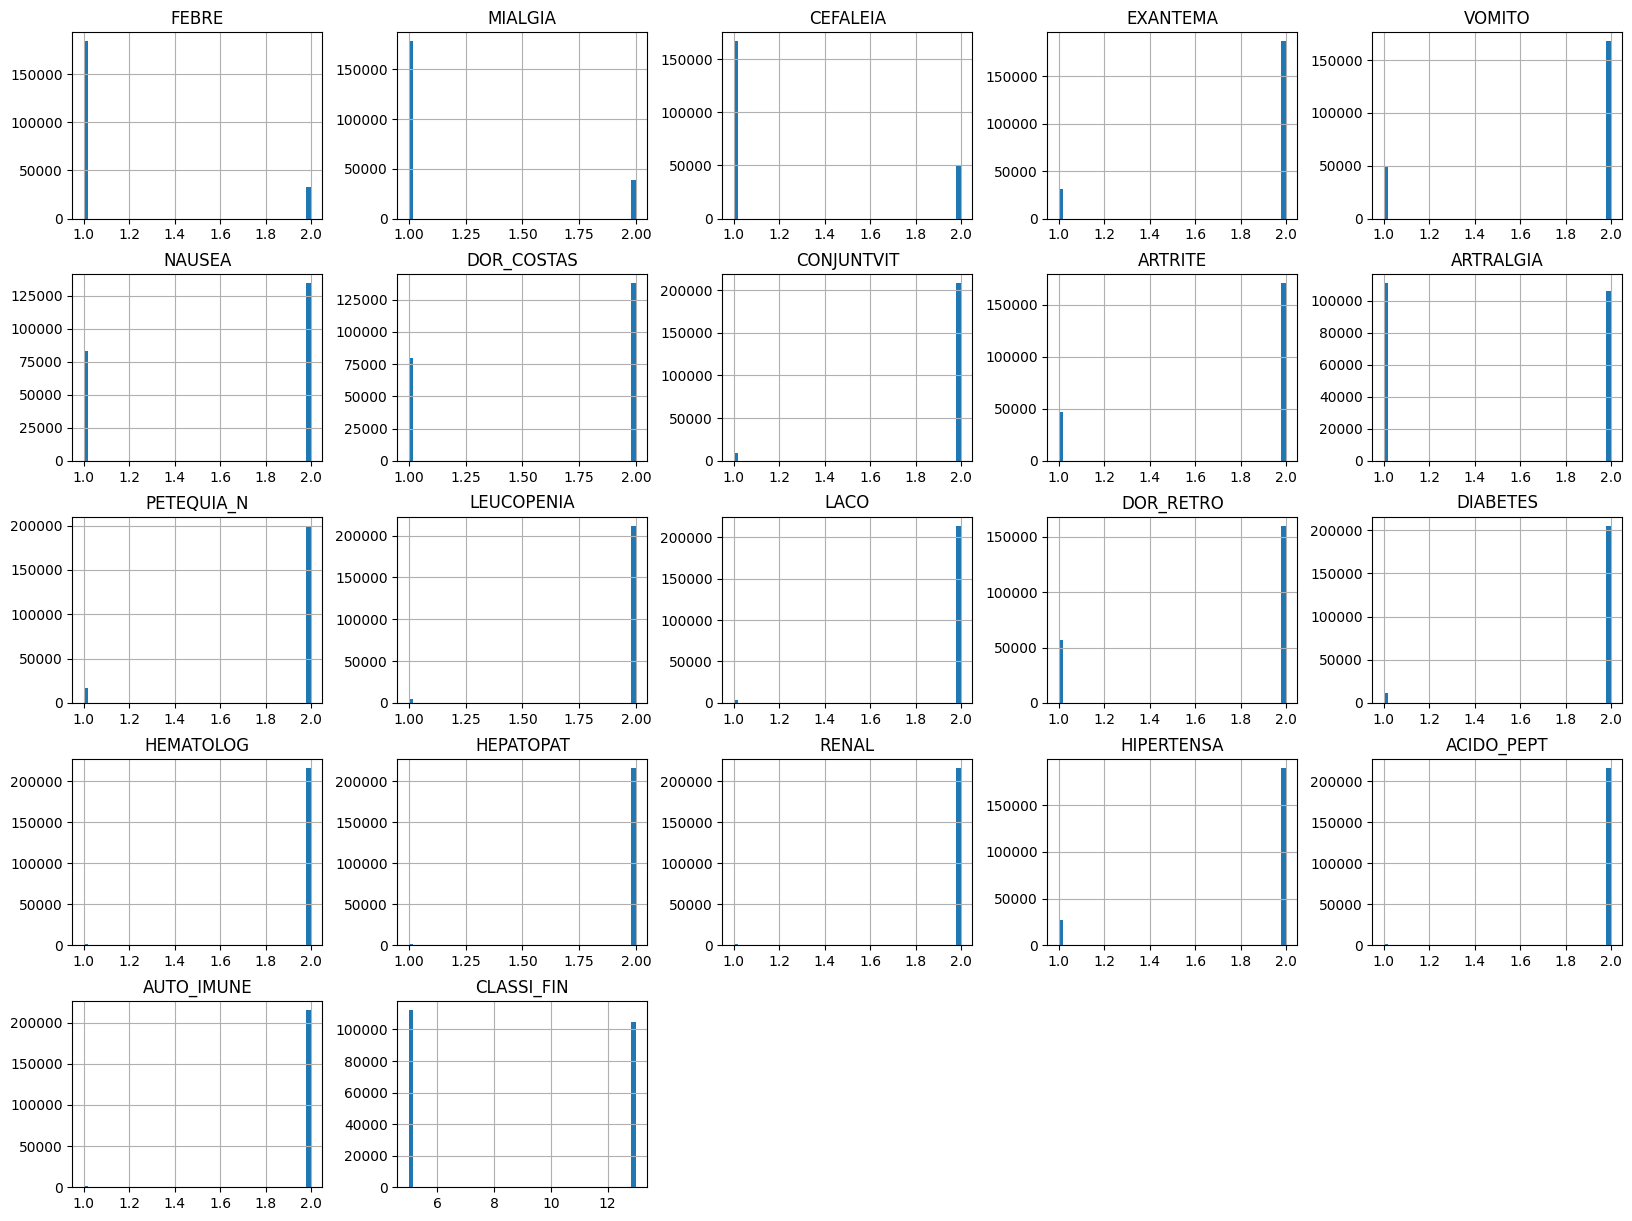

In [77]:
df.hist(bins=50, figsize=(20,15))

In [78]:
df_corr = df.corr()

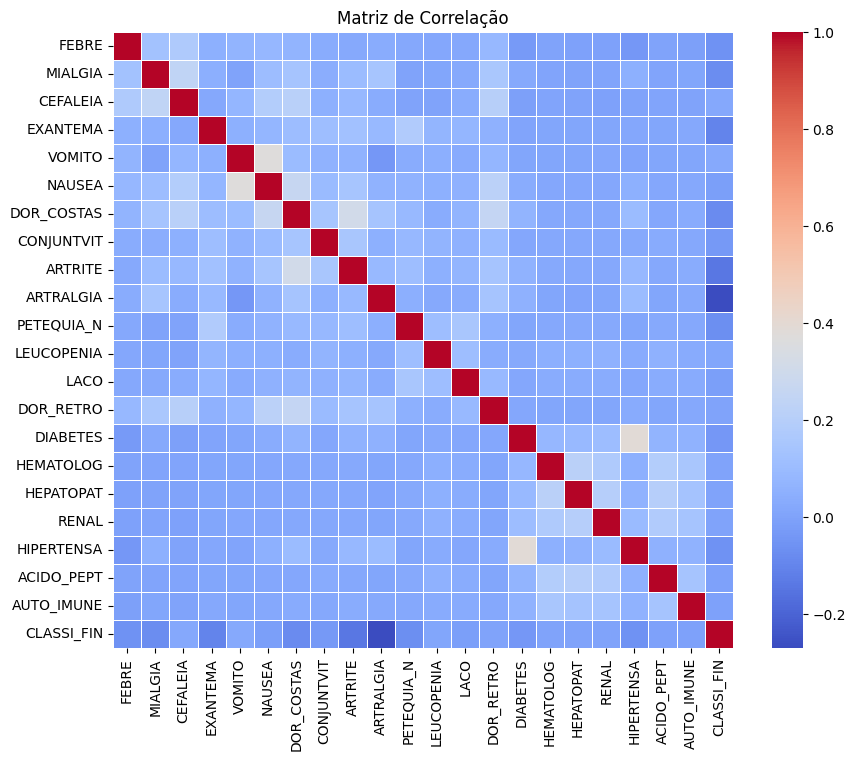

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualização da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

In [80]:
df.corr()["CLASSI_FIN"].sort_values(ascending=False)

CLASSI_FIN    1.000000
VOMITO        0.026588
CEFALEIA      0.021629
LEUCOPENIA    0.009705
HEPATOPAT     0.001374
DOR_RETRO     0.000525
RENAL        -0.000967
HEMATOLOG    -0.001643
ACIDO_PEPT   -0.003364
AUTO_IMUNE   -0.003791
LACO         -0.012287
NAUSEA       -0.012535
CONJUNTVIT   -0.032050
DIABETES     -0.038242
FEBRE        -0.056711
HIPERTENSA   -0.057445
PETEQUIA_N   -0.067828
MIALGIA      -0.071409
DOR_COSTAS   -0.077340
EXANTEMA     -0.104721
ARTRITE      -0.143917
ARTRALGIA    -0.269788
Name: CLASSI_FIN, dtype: float64

In [89]:
# Separar linhas campo classi_fin valor 13 e 5

# Criar um dataframe que contém apenas as duas classes de interesse
df_analise = df[df["CLASSI_FIN"].isin([5.0, 13.0])]

# Agora a correlação funcionará pois existem valores diferentes (5 e 13)
correlacao = df_analise.corr()["CLASSI_FIN"].sort_values(ascending=False)
print(correlacao)

correlacao.value_counts()



CLASSI_FIN    1.000000
VOMITO        0.026588
CEFALEIA      0.021629
LEUCOPENIA    0.009705
HEPATOPAT     0.001374
DOR_RETRO     0.000525
RENAL        -0.000967
HEMATOLOG    -0.001643
ACIDO_PEPT   -0.003364
AUTO_IMUNE   -0.003791
LACO         -0.012287
NAUSEA       -0.012535
CONJUNTVIT   -0.032050
DIABETES     -0.038242
FEBRE        -0.056711
HIPERTENSA   -0.057445
PETEQUIA_N   -0.067828
MIALGIA      -0.071409
DOR_COSTAS   -0.077340
EXANTEMA     -0.104721
ARTRITE      -0.143917
ARTRALGIA    -0.269788
Name: CLASSI_FIN, dtype: float64


CLASSI_FIN
 1.000000    1
 0.026588    1
 0.021629    1
 0.009705    1
 0.001374    1
 0.000525    1
-0.000967    1
-0.001643    1
-0.003364    1
-0.003791    1
-0.012287    1
-0.012535    1
-0.032050    1
-0.038242    1
-0.056711    1
-0.057445    1
-0.067828    1
-0.071409    1
-0.077340    1
-0.104721    1
-0.143917    1
-0.269788    1
Name: count, dtype: int64

In [ ]:
# Como não há uma correlação forte entre as variáveis, será utilizado o modelo de Árvore de Decisão que não depende de correlações lineares entre as variáveis.

In [93]:
# Separando as variáveis preditoras (X) da variável alvo (y)
X = df.drop(columns=['CLASSI_FIN']) # Variáveis características
y = np.log1p(df['CLASSI_FIN']) # O que eu quero prever. (Target)

In [94]:
# Separando as bases em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), "feature de treinamento +", len(X_test), "teste")

173847 feature de treinamento + 43462 teste


In [95]:
# Criando e treinando o modelo de regressão linear
from sklearn.linear_model import LinearRegression

regressaoLinear = LinearRegression()
regressaoLinear.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
previsoes = regressaoLinear.predict(X_test)

In [96]:
# Avaliando o desempenho do modelo

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, previsoes)
mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.1611935944965091
MAE: 0.3799024999813492
R²: 0.10108809265187102


In [98]:
from sklearn.ensemble import RandomForestRegressor

randomForest = RandomForestRegressor()
randomForest.fit(X_train, y_train)

previsoes = randomForest.predict(X_test)

# Avaliando o desempenho do modelo

rmse = mean_squared_error(y_test, previsoes)
mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.1623325504853654
MAE: 0.3711912995068207
R²: 0.09473659274564772


In [100]:
X_train.shape

(173847, 21)